# Notebook to see the best dataset statistics -> to use in report

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import numpy as np
import joblib
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

c:\Users\danim\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.4' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danim\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading Dataset

In [2]:
# loading the dataset
import unicodedata
def strip_accents_unicode(s):
    return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
pt_stopwords = [strip_accents_unicode(w.lower()) for w in stopwords.words('portuguese')]

# paths
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

# load; all of them have 2 columns: Text, Label
train = pd.read_csv(train_csv)
val   = pd.read_csv(val_csv)
test  = pd.read_csv(test_csv)

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text, pt_stopwords):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    words = text_str.split()
    cleaned_words = [w for w in words if w not in pt_stopwords]
    
    return " ".join(cleaned_words)

train['text_clean'] = train['Text'].apply(clean_data, args=(pt_stopwords,))
train = train.dropna(subset=['text_clean']).reset_index(drop=True)
val['text_clean']   = val['Text'].apply(clean_data, args=(pt_stopwords,))
val = val.dropna(subset=['text_clean']).reset_index(drop=True)
test['text_clean']  = test['Text'].apply(clean_data, args=(pt_stopwords,))
test = test.dropna(subset=['text_clean']).reset_index(drop=True)

# fit on training texts and transform all splits
tfidf = joblib.load("../artifacts/punctuation_no_stop_words/tfidf_vectorizer.joblib")

X_train = tfidf.transform(train['text_clean'])
X_val   = tfidf.transform(val['text_clean'])
X_test  = tfidf.transform(test['text_clean'])

print("TF-IDF shapes:", X_train.shape, X_val.shape, X_test.shape)

Train: (50587, 2) Val: (6324, 2) Test: (6324, 2)


c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TF-IDF shapes: (50554, 5000) (6321, 5000) (6320, 5000)


## Word Cloud

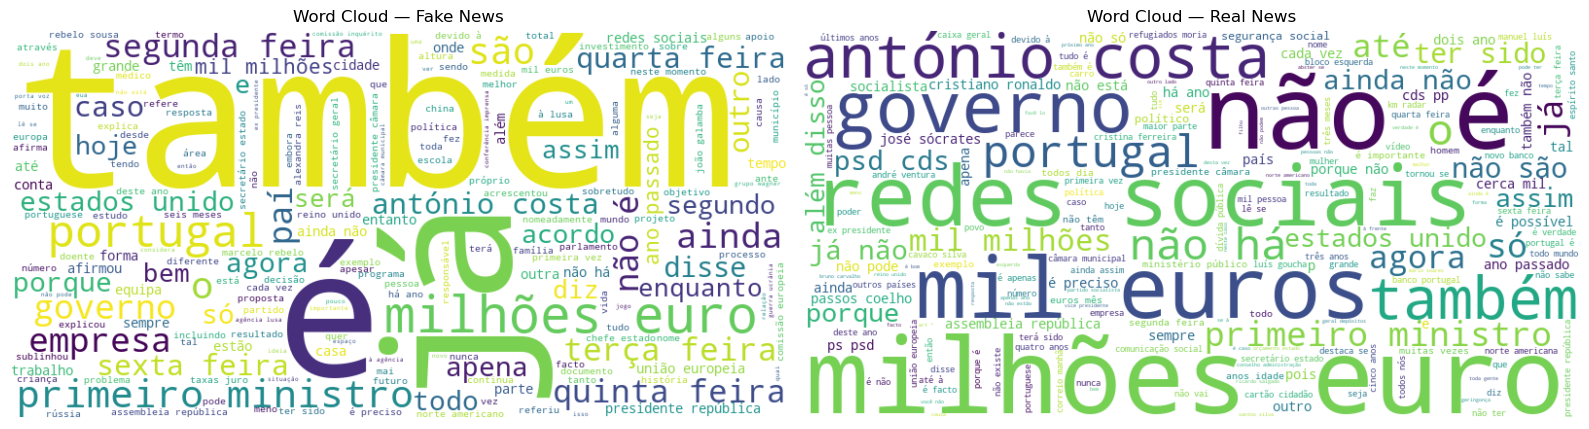

In [ ]:
# Separate Fake vs Real
fake_texts = train.loc[train['Label'] == 1, 'text_clean']
real_texts = train.loc[train['Label'] == 0, 'text_clean']

# Combine all texts per class
fake_combined = " ".join(fake_texts)
real_combined = " ".join(real_texts)
all_combined = " ".join(train['text_clean'])

# Generate Word Clouds
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_combined)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_combined)
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_combined)

# Plot
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Word Cloud — Fake News")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Word Cloud — Real News")
plt.axis("off")

plt.tight_layout()
plt.savefig("../../report/assets/visualizations/wordcloud_fake_real.png")
plt.show()

plt.figure(figsize=(16, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title("Word Cloud — Fake News")
plt.axis("off")
plt.show()

## TF-IDF Heatmap

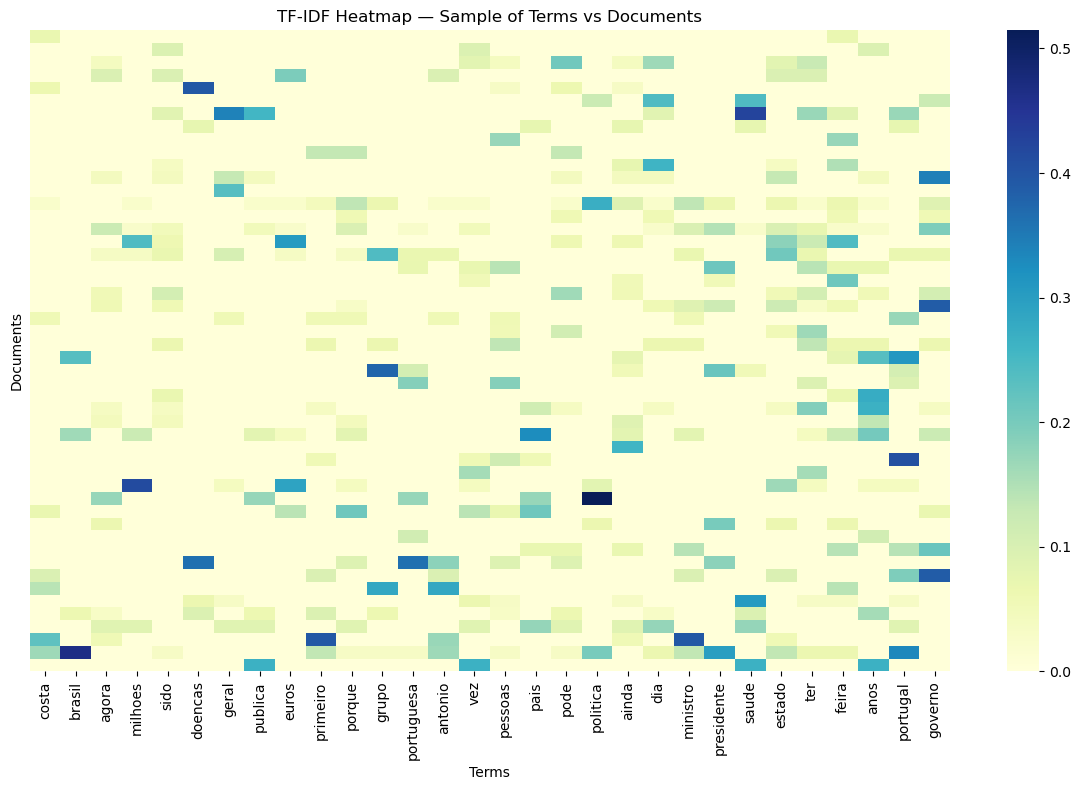

In [4]:
# Take a small sample for visualization
num_samples = 50
X_sample = X_train[:num_samples].toarray()  # dense for heatmap
terms = np.array(tfidf.get_feature_names_out())

# Pick top 30 terms by average TF-IDF for better visualization
top_term_indices = np.argsort(X_sample.mean(axis=0))[-30:]
X_sample_top = X_sample[:, top_term_indices]
terms_top = terms[top_term_indices]

plt.figure(figsize=(12, 8))
sns.heatmap(X_sample_top, cmap="YlGnBu", yticklabels=False, xticklabels=terms_top)
plt.title("TF-IDF Heatmap — Sample of Terms vs Documents")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.tight_layout()
plt.savefig("../../report/assets/visualizations/tfidf_heatmap.png")
plt.show()
